# Demonstration of Kologorov Arnold Network (KAN)

In [190]:
import torch
from kan import KAN
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Generate data from $f(x_1, x_2) = x_1 x_2$ and train a KAN to approximate it.

In [ ]:
sobol = torch.quasirandom.SobolEngine(dimension=3)
X = sobol.draw(10000)
f = lambda X: X[:, 0] * X[:, 1]
F = f(X*2-1).reshape(-1, 1)
X, F = X.to(device), F.to(device)

In [192]:
model = KAN([2, 2, 1])
model.to(device)

checkpoint directory created: ./model
saving model version 0.0


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [193]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [197]:
pbar = tqdm(range(10000))
for i in pbar:
    optimizer.zero_grad()
    F_pred = model(X)
    loss = ((F_pred - F)**2).mean()
    loss.backward()
    optimizer.step(lambda: loss)
    pbar.set_description(f"loss: {loss.item()}")

    

loss: 6.307137478955838e-09: 100%|██████████| 10000/10000 [03:00<00:00, 55.48it/s]


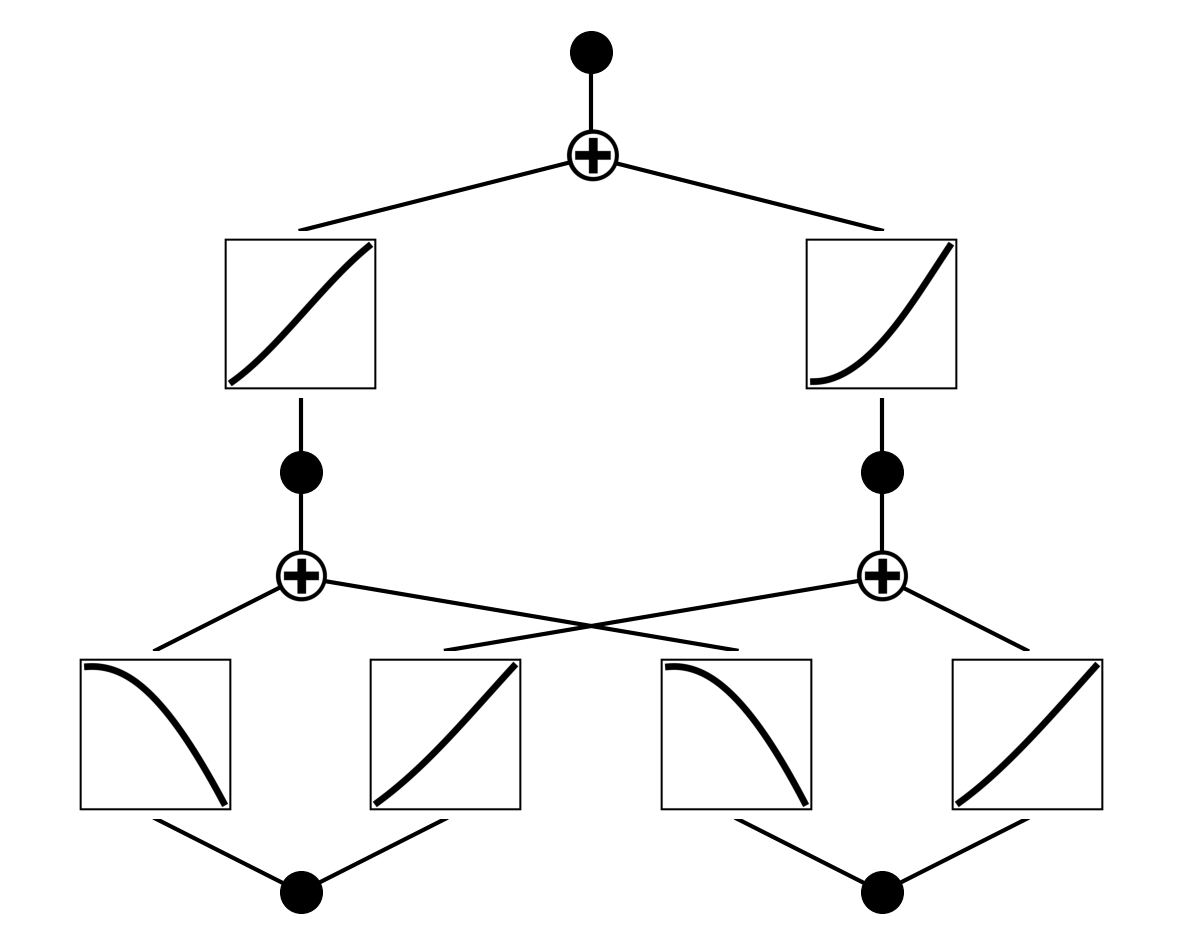

In [178]:
model.plot(scale=1.5, beta=100)